In [1]:
import acgan
import tqdm
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
import matplotlib.pyplot as plt
BATCH_SIZE = 128
acgan.data.DATA_DIR = '/data/marinodl/tensorflow_datasets'
session = tf.InteractiveSession()


In [2]:
#tfds.list_builders()

In [3]:
dataset, info = acgan.data.load_celeb_a(BATCH_SIZE)
input_shape = dataset.output_shapes.as_list()

Instructions for updating:
Colocations handled automatically by placer.


W0328 20:44:19.519068 140716554700608 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
input_shape

[None, 64, 64, 3]

In [5]:
model = acgan.model.DCGAN(
    embedding_size=256,
    generator={'init_shape':(4, 4, 256),
               'units': [1024, 512, 256, 128, 3],
               'kernels': [(3, 3), (3, 3), (4, 4), (4, 4), (4, 4)],
               'strides': [(1, 1), (2, 2), (2, 2), (2, 2), (2, 2)],
               'padding': ['same', 'same', 'same', 'same', 'same']},
    discriminator={'units':[128, 256, 512, 1024],
                   'kernels':4,
                   'strides':2,
                   'dropout':None}
)
# model.noise_rate.init(rate=0.001)

In [6]:
model.generator.compute_output_shape(input_shape = [None, 100])

TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(3)])

In [7]:
iter = dataset.make_one_shot_iterator()
xreal = iter.get_next()

gen = model.generator_trainer(BATCH_SIZE, learning_rate=0.0002)
#dis = model.discriminator_trainer(BATCH_SIZE, input_shape[1:])
dis = model.discriminator_trainer(BATCH_SIZE, xreal=xreal, learning_rate=0.0002)

Instructions for updating:
Use tf.cast instead.


W0328 20:44:46.270777 140716554700608 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


W0328 20:44:46.306417 140716554700608 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [8]:
tdl.core.variables_initializer(gen.variables).run()
tdl.core.variables_initializer(dis.variables).run()
#tf.global_variables_initializer().run()

In [10]:
print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )

step 0 | dis 0.6973944306373596 | gen 0.6931781768798828


In [ ]:
def print_losses():
    print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )
def large_difference(net1, net2, mul):
    n_eval = 1
    loss1 = sum(net1.loss.eval() for i in range(n_eval))/n_eval
    loss2 = sum(net2.loss.eval() for i in range(n_eval))/n_eval
    return mul*loss1 < loss2 

dis_loss, gen_loss = session.run([dis.loss, gen.loss])

try:
    for i in tqdm.tqdm(range(1000)):
        #if (0.5*gen_loss) < dis_loss:
            #for j in range(1):
        _, dis_loss, gen_loss = session.run([dis.step, dis.loss, gen.loss])
        # if (0.0001*dis_loss) < gen_loss:
        for j in range(int(gen_loss//dis_loss)):
            _, dis_loss, gen_loss = session.run([gen.step, dis.loss, gen.loss])
        if i%100 == 0:
            print_losses()
except KeyboardInterrupt:
    pass

  0%|          | 1/1000 [00:00<09:33,  1.74it/s]

step 5520 | dis 0.5246105194091797 | gen 1.0048785209655762


 10%|█         | 101/1000 [00:45<07:19,  2.05it/s]

step 5620 | dis 0.5936484336853027 | gen 0.8338069915771484


 20%|██        | 201/1000 [01:31<06:30,  2.05it/s]

step 5720 | dis 1.1022393703460693 | gen 0.7675875425338745


 30%|███       | 301/1000 [02:16<05:42,  2.04it/s]

step 5820 | dis 0.39437758922576904 | gen 1.1147981882095337


 40%|████      | 401/1000 [03:01<04:52,  2.05it/s]

step 5920 | dis 0.35883569717407227 | gen 1.4042885303497314


 50%|█████     | 501/1000 [03:47<04:04,  2.04it/s]

step 6020 | dis 0.4167781472206116 | gen 1.7980377674102783


 60%|██████    | 601/1000 [04:32<03:15,  2.05it/s]

step 6120 | dis 0.3950740098953247 | gen 1.2253297567367554


 70%|███████   | 701/1000 [05:17<02:26,  2.05it/s]

step 6220 | dis 0.3706495761871338 | gen 1.2666471004486084


 74%|███████▍  | 738/1000 [05:34<01:58,  2.22it/s]

2.6142511

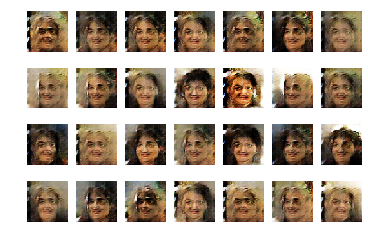

In [46]:
import matplotlib.pyplot as plt
import numpy as np
xsim = dis.xsim.eval()
for i in range(4*7):
    plt.subplot(4,7, i+1)
    plt.imshow(np.squeeze((xsim[i][:,:,:]+1)*0.5))
    plt.axis('off')